<table style="width: 100%;">
  <tr>
    <td style="text-align: left;">
      <h1>Proyecto Series de Tiempo: Precio de la tortilla en Guadalajara</h1>
      <p><b>By:</b> <i>Esteban Javier Berumen Nieto</i></p>
      <p><b>Date:</b> <i>11-10-2024</i></p>
    </td>
    <td style="text-align: right;">
      <img src="LOGO.jpg" style="width:150px;"/>
    </td>
  </tr>
</table>

## **Introducción**

Tenemos un Dataset sobre el precio por Kg de la tortilla en México, dentro del dataset podemos encontrar varias columnas como son **State, City, Year, Month, Day, Store type, Price per kilogram**. Sin embargo, para realizar un mejor análisis, solo tomaremos en cuenta el estado de **Jalisco**, y la predicción principal se dará para la ciudad de **Guadalajara** en las tiendas pequeñas.

El Dataset fue sacado de una página de **[Kaggle](https://www.kaggle.com/datasets/richave/tortilla-prices-in-mexico/data)**, sin embargo, estos datos son extraídos de una página del gobierno de México: **[SNIIM](http://www.economia-sniim.gob.mx/Tortilla.asp)** (Sistema Nacional de Información e Integración de Mercados). Este organismo recaba los datos de tiendas pequeñas y grandes en las ciudades, cada lunes, miércoles y viernes.

Conocer o poder predecir el precio de la tortilla en México es un gran factor que puede ayudarnos a entender distintas dinámicas económicas en el país. Este alimento es el más consumido en el mercado mexicano, lo que lo convierte en un buen reflejo de fenómenos económicos como la **inflación**. 

El conocimiento preciso del precio de la tortilla en México tiene implicaciones profundas para diversos sectores y actores económicos. La tortilla es un alimento básico en la dieta de millones de mexicanos, y su demanda es constante. Sin embargo, su precio fluctúa debido a factores como los costos de producción, transporte, variabilidad del clima, y las dinámicas del mercado de granos, como el maíz. Por lo tanto, entender y predecir estas fluctuaciones es esencial para tomar decisiones informadas.

### Impacto para consumidores

Desde la perspectiva de los **consumidores**, la tortilla es un componente esencial de la canasta básica. Las variaciones en su precio impactan directamente el poder adquisitivo de las familias mexicanas, especialmente aquellas de bajos recursos, donde incluso pequeños incrementos pueden tener repercusiones importantes en la economía doméstica. Predecir el precio podría ayudar a anticipar períodos de mayor gasto, permitiendo a las familias planificar mejor su consumo.

### Impacto para inversionistas y empresas

Para **inversionistas y empresas**, el precio de la tortilla ofrece un indicador útil de la estabilidad económica y la inflación. En sectores agroindustriales o en la distribución de alimentos, predecir el comportamiento del precio de la tortilla permite optimizar cadenas de suministro y gestionar costos. Para las empresas involucradas en la producción de insumos como el maíz, harina o gas, la capacidad de anticipar movimientos en el precio de la tortilla podría ayudar en la negociación de contratos futuros o en la toma de decisiones estratégicas, como la expansión de infraestructura o el almacenamiento de productos.

### Impacto para el gobierno

Los **gobiernos locales y federales** también pueden beneficiarse del análisis y la predicción del precio de la tortilla al diseñar políticas públicas de apoyo a la población más vulnerable. En períodos de alza de precios, las autoridades podrían intervenir con subsidios, programas de apoyo alimentario o regulación temporal del mercado para estabilizar el precio y mitigar su impacto sobre la inflación general.

### Impacto para la población en general

La **población en general** se ve beneficiada porque la tortilla es un bien de primera necesidad y un símbolo de identidad cultural, y el tener un modelo predictivo fiable sobre su precio podría ayudar a que más mexicanos comprendan cómo los factores económicos y climáticos influyen en sus gastos diarios. Esto fomenta una mejor comprensión de la economía y el comportamiento de los precios en general, proporcionando información valiosa para la toma de decisiones cotidianas.


## **Objetivo**

Realizar un analisis en el cual podamos descubrir las variables que afectan al precio de la toritalla desde hecho externos, politicos o incluso si el precio de las tiendas grandes afecta a las tiendas pequeña, para con ello lograr una prediccion del precio de los siguientes 6 mese 

## **Importación de Datos y Librerías**

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from matplotlib import pyplot
import statsmodels.api as sm
from sklearn.preprocessing import PowerTransformer
import numpy as np
from statsforecast.models import SeasonalNaive, Naive
from sklearn.linear_model import LinearRegression,  ElasticNet,  Lasso, Ridge
from sklearn.metrics import mean_squared_error


c:\Users\esteb\miniconda3\envs\ITESO\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('tortilla_prices.csv')
df

,State,City,Year,Month,Day,Store type,Price per kilogram
0,Aguascalientes,Aguascalientes,2007,1,10,Mom and Pop Store,9.90
1,Baja California,Mexicali,2007,1,10,Mom and Pop Store,NaN
2,Baja California,Tijuana,2007,1,10,Mom and Pop Store,10.00
3,Baja California Sur,La Paz,2007,1,10,Mom and Pop Store,10.00
4,Campeche,Campeche,2007,1,10,Mom and Pop Store,10.00
...,...,...,...,...,...,...,...
284389,Veracruz,Coatzacoalcos,2024,7,8,Big Retail Store,12.50
284390,Veracruz,Veracruz,2024,7,8,Big Retail Store,13.60
284391,Veracruz,Xalapa,2024,7,8,Big Retail Store,14.33
284392,Yucatán,Mérida,2024,7,8,Big Retail Store,13.40


## **Tratamiento de Datos**

Las columnas **Year, Month** se usaran para crear un índice de tipo fecha, ademas dado que la columna **Day** no cuenta con valores continuos, ya que las mediciones en distintas zonas,  solo la usare para sacar el promedio del precio de manera mensual, para esto me apoye de la funcion **group by** y la funcion de agregacion para generar una tabla que agrupara por cada convinacion unica de Años, Mes y que sacara la media de estos datos, para luego covertir las columnas de agrupacion en el indice del dataset ya convertidas a fecha.  

Con estas tecnicas ademas de reducir los datos para poder hacer un analisis de manera mensual, tambien imputamos los datos nulos al sacar la media por mes, sin embargo aun asi se produce un nulo, en el **2020-06**, el cual es cuasado por la ausencia total de datos en ese mes esto se debe a que por cuestiones de pandemia Covid-19 el organizmo que recolecta los datos no pudo recabarlos. El tratamiento de este dato nulo fue imputarlo con el valor inmediatamente anterior

In [3]:
df.isna().sum()

State                    0
City                     0
Year                     0
Month                    0
Day                      0
Store type               0
Price per kilogram    6390
dtype: int64

In [4]:
df_jalisco = df[df['State'] == 'Jalisco']
combinations = df_jalisco[['City', 'Store type']].drop_duplicates()

dfs = {}

for index, row in combinations.iterrows():
    city = row['City']
    store_type = row['Store type']
    
    df_filtered = df_jalisco[(df_jalisco['City'] == city) & (df_jalisco['Store type'] == store_type)]
    
    df_filtered = df_filtered.groupby(['Year', 'Month']).agg({
        'Price per kilogram': 'mean'
    }).reset_index()

    df_filtered['Date'] = pd.to_datetime(df_filtered['Year'].astype(str) + '-' + df_filtered['Month'].astype(str) + '-01')
    df_filtered.set_index('Date', inplace=True)
    df_filtered.drop(columns=['Year', 'Month'], inplace=True)

    df_name = f"{city.replace(' ', '_')}_{store_type.replace(' ', '_')}"
    
    dfs[df_name] = df_filtered

In [5]:
for i in dfs.keys():
    print(i)

Guadalajara_Mom_and_Pop_Store
ZM Guadalajara_Mom_and_Pop_Store
Guadalajara_Big_Retail_Store
ZM Guadalajara_Big_Retail_Store


In [6]:
for df in dfs.keys():
    print(dfs[df].isna().sum())

Price per kilogram    1
dtype: int64
Price per kilogram    1
dtype: int64
Price per kilogram    1
dtype: int64
Price per kilogram    1
dtype: int64


In [7]:
for df_name, df_filtered in dfs.items():
    df_filtered.fillna(method='ffill', inplace=True)
    df_filtered.fillna(method='bfill', inplace=True)

C:\Users\esteb\AppData\Local\Temp\ipykernel_15684\2274903202.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered.fillna(method='ffill', inplace=True)
C:\Users\esteb\AppData\Local\Temp\ipykernel_15684\2274903202.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered.fillna(method='bfill', inplace=True)


In [8]:
for df in dfs.keys():
    print(dfs[df].isna().sum())

Price per kilogram    0
dtype: int64
Price per kilogram    0
dtype: int64
Price per kilogram    0
dtype: int64
Price per kilogram    0
dtype: int64


In [9]:
data = dfs["Guadalajara_Mom_and_Pop_Store"]
df = pd.Series(data = data["Price per kilogram"], index=data.index)
data = dfs["Guadalajara_Big_Retail_Store"]
df_GB = pd.Series(data = data["Price per kilogram"], index=data.index)
data = dfs["ZM\xa0Guadalajara_Big_Retail_Store"]
df_ZMB = pd.Series(data = data["Price per kilogram"], index = data.index)
data = dfs["ZM\xa0Guadalajara_Mom_and_Pop_Store"]
df_ZM = pd.Series(data = data["Price per kilogram"], index = data.index)

## **Entrenamiento y Prueba**

In [10]:
train = df.iloc[:192]
test = df.iloc[192:]
print(len(train), len(test))
horizon = len(test)

192 19


In [11]:
train.tail(12)

Date
2022-01-01    16.000000
2022-02-01    16.000000
2022-03-01    19.500000
2022-04-01    20.000000
2022-05-01    21.230769
2022-06-01    22.000000
2022-07-01    22.000000
2022-08-01    22.000000
2022-09-01    22.310000
2022-10-01    22.926923
2022-11-01    23.850000
2022-12-01    24.009231
Name: Price per kilogram, dtype: float64

In [12]:
test.head(12)

Date
2023-01-01    24.143077
2023-02-01    24.230000
2023-03-01    24.230000
2023-04-01    24.230000
2023-05-01    24.230000
2023-06-01    24.590000
2023-07-01    24.743846
2023-08-01    24.846154
2023-09-01    24.855385
2023-10-01    24.843846
2023-11-01    24.850000
2023-12-01    24.855833
Name: Price per kilogram, dtype: float64

El 80 % serian 168 meses   
El 20 % seian 43 meses

## **Visualización de Datos**

In [13]:
df

Date
2007-01-01     9.042353
2007-02-01     8.519130
2007-03-01     8.512308
2007-04-01     8.523636
2007-05-01     8.534783
                ...    
2024-03-01    24.850000
2024-04-01    24.864615
2024-05-01    24.830833
2024-06-01    24.914167
2024-07-01    24.920000
Name: Price per kilogram, Length: 211, dtype: float64

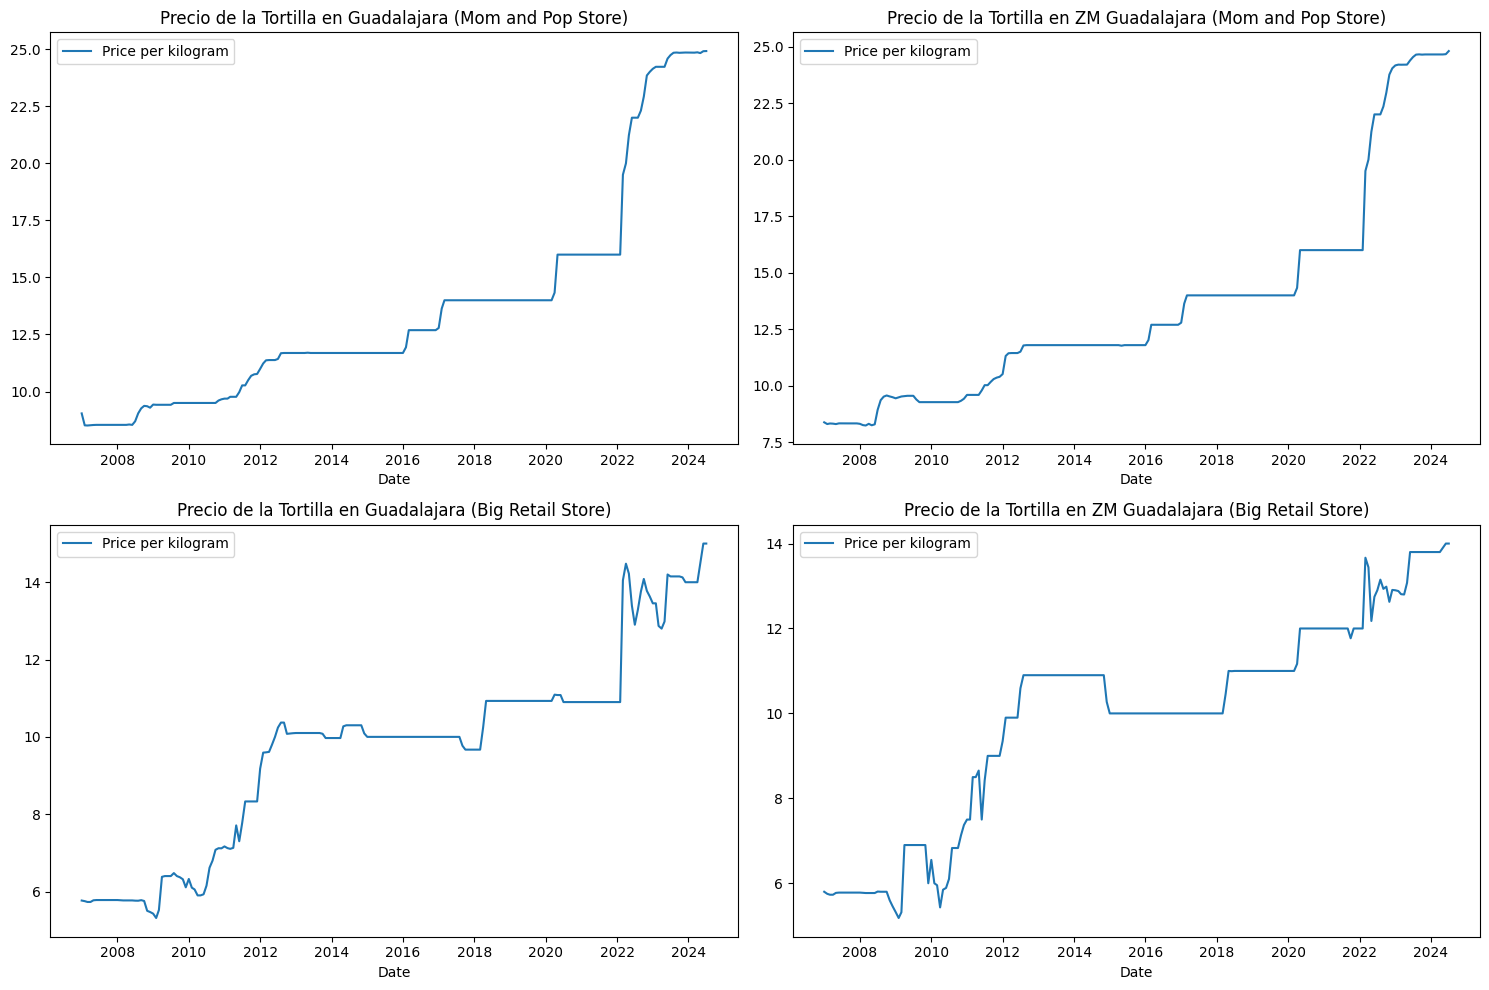

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (df_name, df_filtered) in enumerate(dfs.items()):
    ax = axes[i // 2, i % 2]

    sns.lineplot(data=df_filtered, ax=ax)
    city, store_type = df_name.split('_')[0], df_name.split('_')[1:]
    ax.set_title(f"Precio de la Tortilla en {city} ({' '.join(store_type)})")

plt.tight_layout()
plt.show()

Lo que podemos ver de manera grafica es como en general nuestros datos principales *grafica(1,1)* tiene tendecia a subir, vemos varios periodos de estancamiento en el precio ademas de una importante subida de precio en el 2022 la cual como dice **[CNN Mexico](https://cnnespanol.cnn.com/2022/08/15/asi-ha-aumentado-el-precio-de-la-tortilla-en-todo-mexico-en-los-ultimos-10-anos-orix)** Se debio a diveros factores como lo fueron la panemia Covid-19, la Gerra de Ucrania e incluso el aumento de precios del acero

<Axes: >

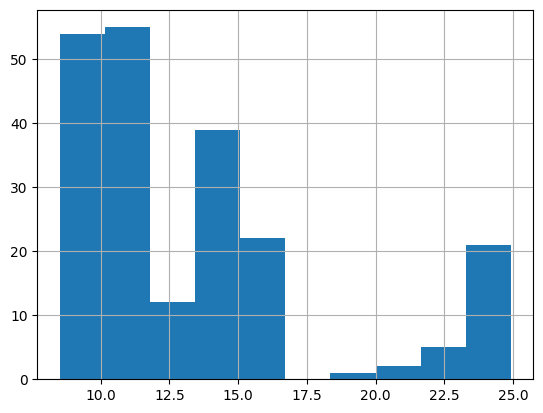

In [15]:
df.hist()

<Axes: ylabel='Density'>

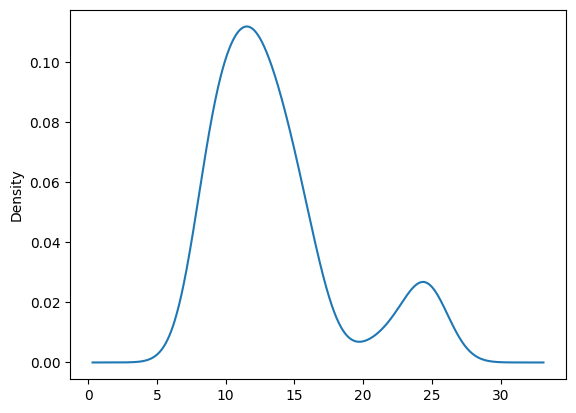

In [16]:
df.plot.density()

In [17]:
piv_index = getattr(df_filtered.index, 'year')
piv_seson = getattr(df_filtered.index, 'month')
piv = pd.pivot_table(df_filtered, index=piv_index, columns=piv_seson, values='Price per kilogram')

([], [])

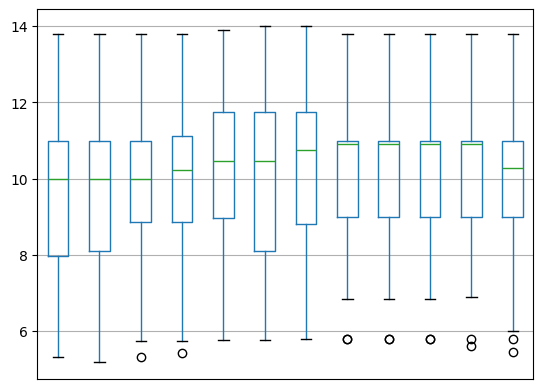

In [18]:
piv.boxplot()
plt.xticks([])

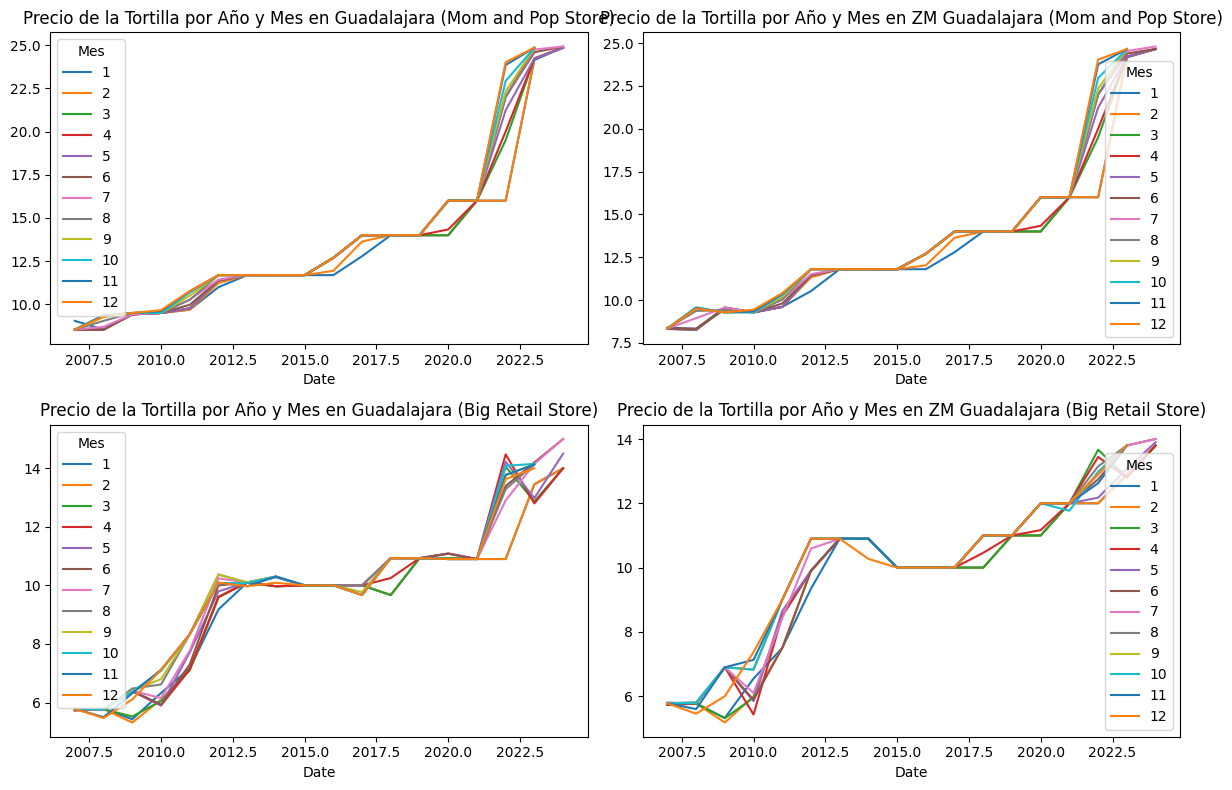

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (df_name, df_filtered) in enumerate(dfs.items()):
    ax = axes[i // 2, i % 2]
    
    
    piv_index = getattr(df_filtered.index, 'year')
    piv_seson = getattr(df_filtered.index, 'month')
    piv = pd.pivot_table(df_filtered, index=piv_index, columns=piv_seson, values='Price per kilogram')
    piv.plot(ax=ax, figsize=(12, 8))
    
    ax.legend(pd.unique(piv_seson), title="Mes")
    city, store_type = df_name.split('_')[0], df_name.split('_')[1:]
    ax.set_title(f"Precio de la Tortilla por Año y Mes en {city} ({' '.join(store_type)})")

plt.tight_layout()
plt.show()

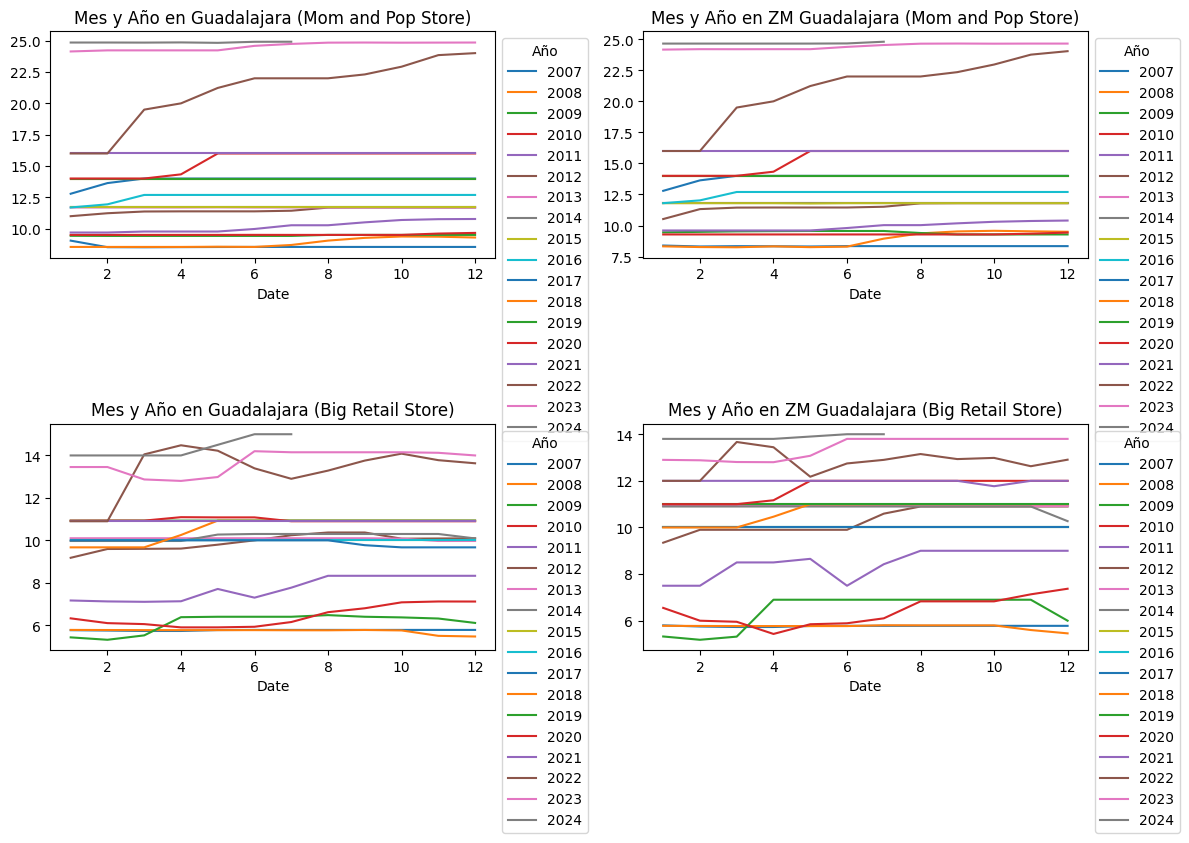

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (df_name, df_filtered) in enumerate(dfs.items()):
    ax = axes[i // 2, i % 2]
    
    piv_index = getattr(df_filtered.index, 'year')
    piv_seson = getattr(df_filtered.index, 'month')
    piv = pd.pivot_table(df_filtered, index=piv_seson, columns=piv_index, values='Price per kilogram')
    piv.plot(ax=ax, figsize=(12, 8))
    
    ax.legend(pd.unique(piv_index), title="Año", loc='upper left', bbox_to_anchor=(1, 1))
    city, store_type = df_name.split('_')[0], df_name.split('_')[1:]
    ax.set_title(f"Mes y Año en {city} ({' '.join(store_type)})")

plt.tight_layout()
plt.show()

(<Figure size 640x480 with 1 Axes>,
 array([0.16339869, 0.22766885, 0.32897603, 0.29956427, 0.45098039,
        0.51960784, 0.57407407, 0.54248366, 0.55991285, 0.58169935,
        0.56862745, 0.54248366, 0.50326797, 0.45098039, 0.38562092,
        0.30718954, 0.21568627, 0.11111111]),
 array([ 9,  6, 10,  8, 11,  7,  5, 12, 13,  4, 14,  2, 15,  3,  1, 16,  0,
        17], dtype=int64),
 array([ 0,  1,  2,  3,  4, 14, 15, 16, 17]))

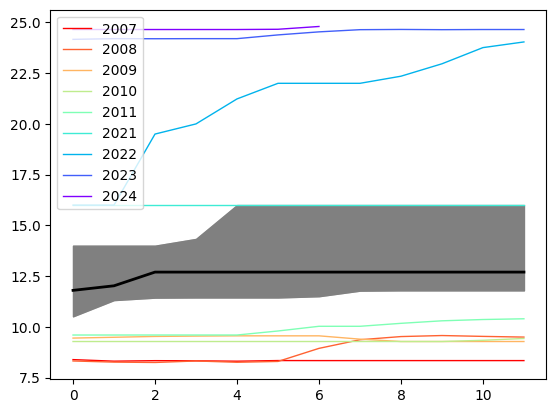

In [21]:
piv_index = getattr(data.index, 'year')
piv_season = getattr(data.index, 'month')

piv = pd.pivot_table(data=pd.DataFrame(data=data.values, index=data.index, columns=['values']), index=data.index.year, columns=data.index.month)

sm.graphics.fboxplot(data=piv, labels=piv.index)

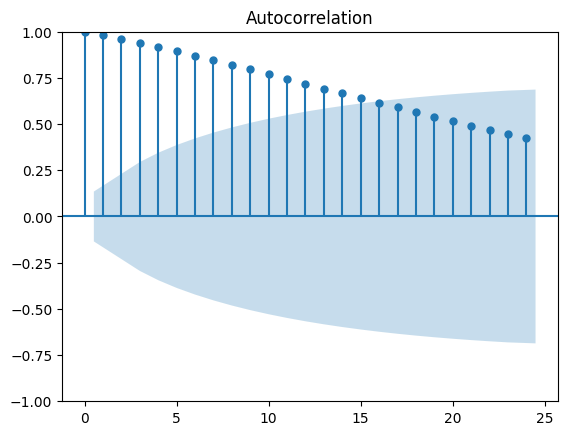

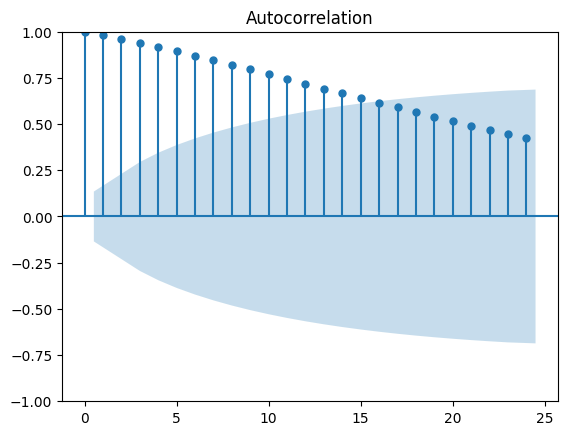

In [22]:
plot_acf(df, lags= 24)

## **Descompocicion**

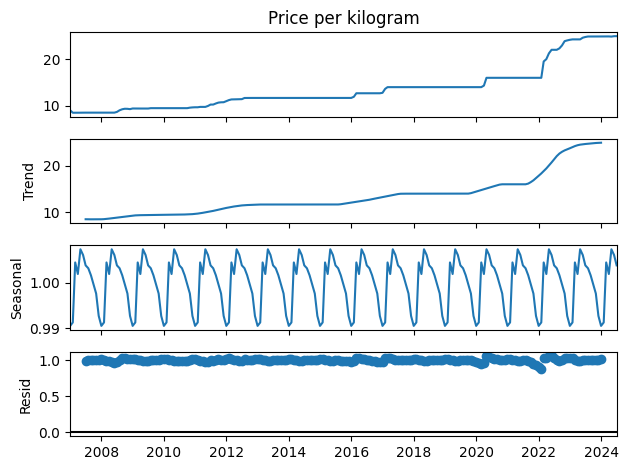

In [23]:
result = seasonal_decompose(df, model='multiplicative')
result.plot()
pyplot.show()

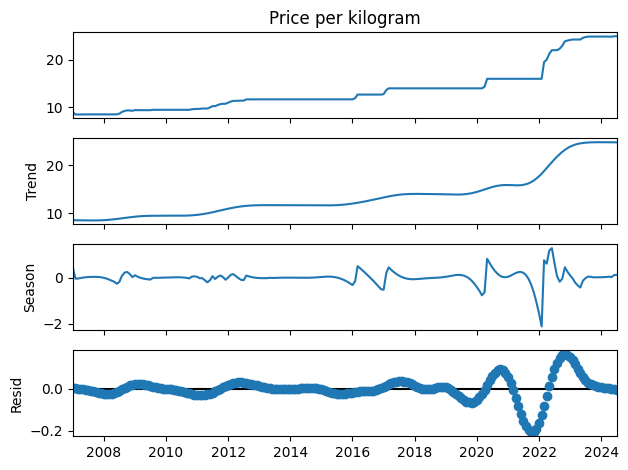

In [24]:
stl = STL(df, seasonal=3, trend = 13)
res = stl.fit()
fig = res.plot()

Vemos como no existe una estacionalidad como tal, cosa la cual era esperado depues de ver la serie de tiempo original, lo que si podemos ver es como los errores se ajustan mejor con la descompsicion multiplicativa.

## **Caracteristicas y Estadiscas**

In [25]:
df.describe()

count    211.000000
mean      13.588347
std        4.635003
min        8.512308
25%        9.871538
50%       11.690000
75%       14.000000
max       24.920000
Name: Price per kilogram, dtype: float64

In [26]:
df.skew()

1.3162658745066194

In [27]:
df.kurtosis()

0.8764373192038315

## **Transformcaiones**

In [28]:
train_index = train.index  
test_index = test.index

In [29]:
train = train.values.reshape(-1, 1)
test = test.values.reshape(-1, 1)

In [30]:
pt = PowerTransformer(method='box-cox')
Train_boxcox = pd.Series(data = pt.fit_transform(train).flatten(), index = train_index)
Test_boxcox = pd.Series(data = pt.transform(test).flatten(), index = test_index)

## **Modelos**

### **Sesonal Naive**

In [31]:
model_sn = SeasonalNaive(season_length=12)
model_sn = model_sn.fit(y=Train_boxcox)
y_hat_dict = model_sn.predict(h=horizon)

y_hat_dict['mean']

array([1.1744144, 1.1744144, 1.7929949, 1.8645785, 2.0271678, 2.1200309,
       2.1200309, 2.1200309, 2.1557412, 2.2240872, 2.3200955, 2.3359504,
       1.1744144, 1.1744144, 1.7929949, 1.8645785, 2.0271678, 2.1200309,
       2.1200309], dtype=float32)

In [32]:
Y_pred_df = pd.DataFrame({'Sesonal_Naive':y_hat_dict["mean"]}, index = test_index)

In [33]:
model_sn.predict_in_sample()["fitted"]

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -1.3623985 , -1.709545  , -1.714338  ,
       -1.7063836 , -1.6985768 , -1.6949291 , -1.6949291 , -1.6949291 ,
       -1.6949291 , -1.6949291 , -1.6949291 , -1.6949291 , -1.6949291 ,
       -1.6949291 , -1.6949291 , -1.6949291 , -1.6833053 , -1.6949291 ,
       -1.5876744 , -1.36098   , -1.2266341 , -1.1624641 , -1.171192  ,
       -1.2097309 , -1.1291984 , -1.1345515 , -1.1345515 , -1.1345515 ,
       -1.1345515 , -1.1345515 , -1.1345515 , -1.0884855 , -1.0884855 ,
       -1.0884855 , -1.0884855 , -1.0884855 , -1.0884855 , -1.0884855 ,
       -1.0884855 , -1.0884855 , -1.0884855 , -1.0867285 , -1.0884855 ,
       -1.0884855 , -1.0884855 , -1.0884855 , -1.0281934 , -0.99851954,
       -0.98196375, -0.98196375, -0.9382852 , -0.9382852 , -0.9382852 ,
       -0.83038706, -0.6798993 , -0.6798993 , -0.56729263, -0.48

In [34]:
residuals_train = Train_boxcox[12:] - model_sn.predict_in_sample()['fitted'][12:]
residuals_test = Test_boxcox - y_hat_dict['mean']
rmse_train = np.sqrt(np.mean(residuals_train**2))
rmse_test = np.sqrt(np.mean(residuals_test**2))

In [35]:
tabla_modelos = pd.DataFrame(columns=['Modelo', 'RMSE Train', 'RMSE Test', 'Parametros'], data = [['Seasonal Naive', rmse_train, rmse_test, 0]])
tabla_modelos

,Modelo,RMSE Train,RMSE Test,Parametros
0,Seasonal Naive,0.373089,0.646123,0


###  **Naive**

In [36]:
model_n = Naive()
model_n = model_n.fit(y=Train_boxcox)
y_hat_dict = model_n.predict(h=horizon)

y_hat_dict['mean']

c:\Users\esteb\miniconda3\envs\ITESO\lib\site-packages\statsforecast\utils.py:282: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fcst = {"mean": _repeat_val(val=y[-1], h=h)}


array([2.3359504, 2.3359504, 2.3359504, 2.3359504, 2.3359504, 2.3359504,
       2.3359504, 2.3359504, 2.3359504, 2.3359504, 2.3359504, 2.3359504,
       2.3359504, 2.3359504, 2.3359504, 2.3359504, 2.3359504, 2.3359504,
       2.3359504], dtype=float32)

In [37]:
Y_pred_df["Naive"] = y_hat_dict['mean']

In [38]:
residuals_train = Train_boxcox[12:] - model_n.predict_in_sample()['fitted'][12:]
residuals_test = Test_boxcox - y_hat_dict['mean']
rmse_train = np.sqrt(np.mean(residuals_train**2))
rmse_test = np.sqrt(np.mean(residuals_test**2))

In [39]:
tabla_modelos = pd.concat([tabla_modelos,
           pd.DataFrame(columns=['Modelo', 'RMSE Train', 'RMSE Test', 'Parametros'],
                        data = [['Navive', rmse_train, rmse_test, 0]])])

In [40]:
tabla_modelos

,Modelo,RMSE Train,RMSE Test,Parametros
0,Seasonal Naive,0.373089,0.646123,0
0,Navive,0.072645,0.068909,0


In [41]:
Y_pred_df.head(1)

,Sesonal_Naive,Naive
Date,,
2023-01-01,1.174414,2.33595


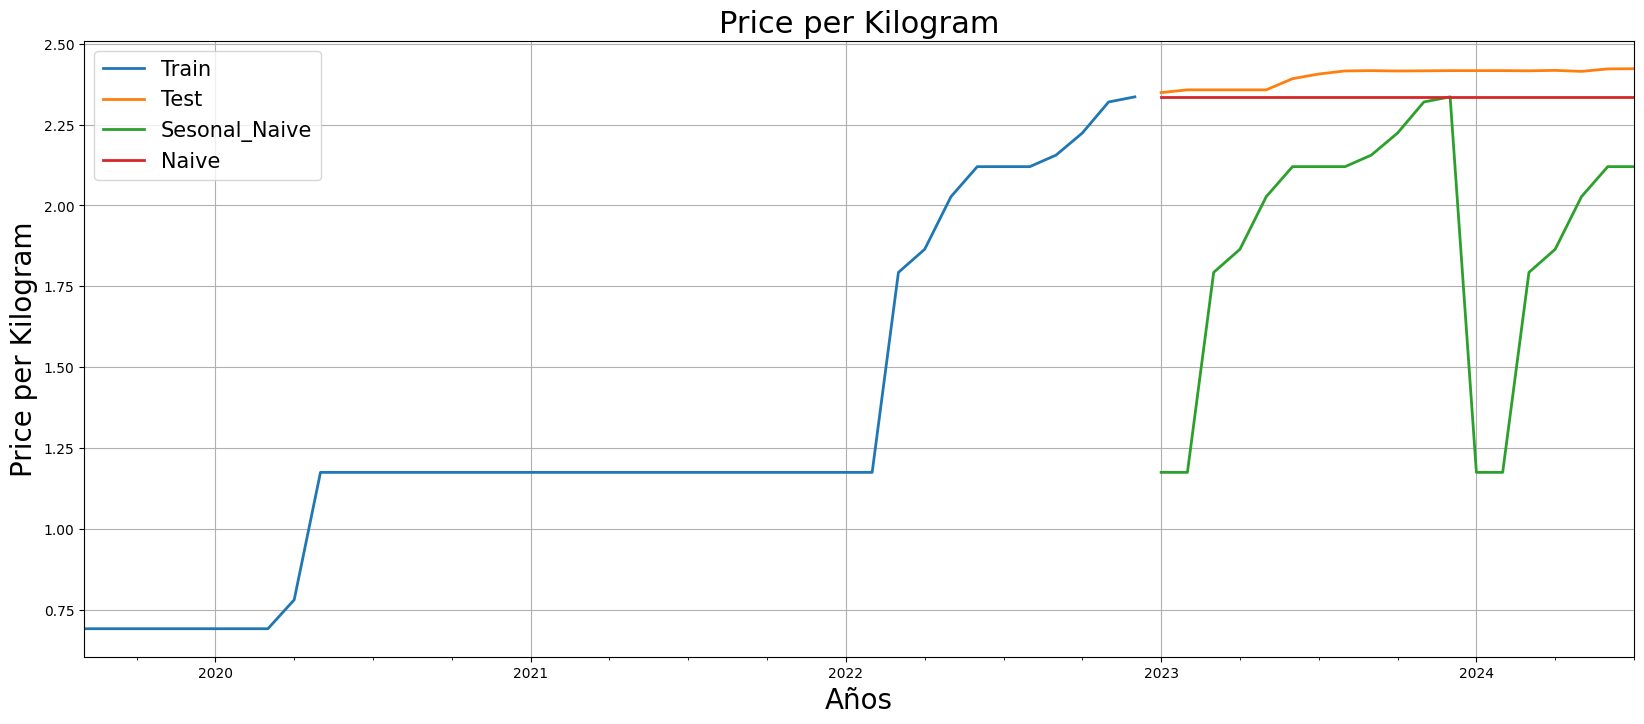

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
plot_df = pd.concat([Train_boxcox, Test_boxcox, Y_pred_df["Sesonal_Naive"], Y_pred_df["Naive"]], axis=1)
plot_df.columns = ['Train', 'Test', 'Sesonal_Naive', 'Naive']

# Plot the values:
plot_df[-60:][['Train', 'Test', 'Sesonal_Naive', 'Naive']].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Price per Kilogram', fontsize=22)
ax.set_ylabel('Price per Kilogram', fontsize=20)
ax.set_xlabel('Años', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()


In [43]:
tabla_modelos

,Modelo,RMSE Train,RMSE Test,Parametros
0,Seasonal Naive,0.373089,0.646123,0
0,Navive,0.072645,0.068909,0


### **Regresion Lineal**

In [44]:
model_lr = LinearRegression()

X_train = np.arange(len(Train_boxcox)).reshape(-1, 1)  
model_lr.fit(X_train, Train_boxcox)

X_test = np.arange(len(Train_boxcox), len(Train_boxcox) + horizon).reshape(-1, 1)

y_hat_train = model_lr.predict(X_train)
y_hat_test = model_lr.predict(X_test)

In [45]:
Y_pred_df["LinearRegression"] = y_hat_test

In [46]:
residuals_train = Train_boxcox[12:] - y_hat_train[12:]
residuals_test = Test_boxcox - y_hat_test
rmse_train = np.sqrt(np.mean(residuals_train**2))
rmse_test = np.sqrt(np.mean(residuals_test**2))


In [47]:
tabla_modelos = pd.concat([tabla_modelos,
           pd.DataFrame(columns=['Modelo', 'RMSE Train', 'RMSE Test', 'Parametros'],
                        data=[['LinearRegression', rmse_train, rmse_test, 1]])])

tabla_modelos

,Modelo,RMSE Train,RMSE Test,Parametros
0,Seasonal Naive,0.373089,0.646123,0
0,Navive,0.072645,0.068909,0
0,LinearRegression,0.229171,0.550063,1


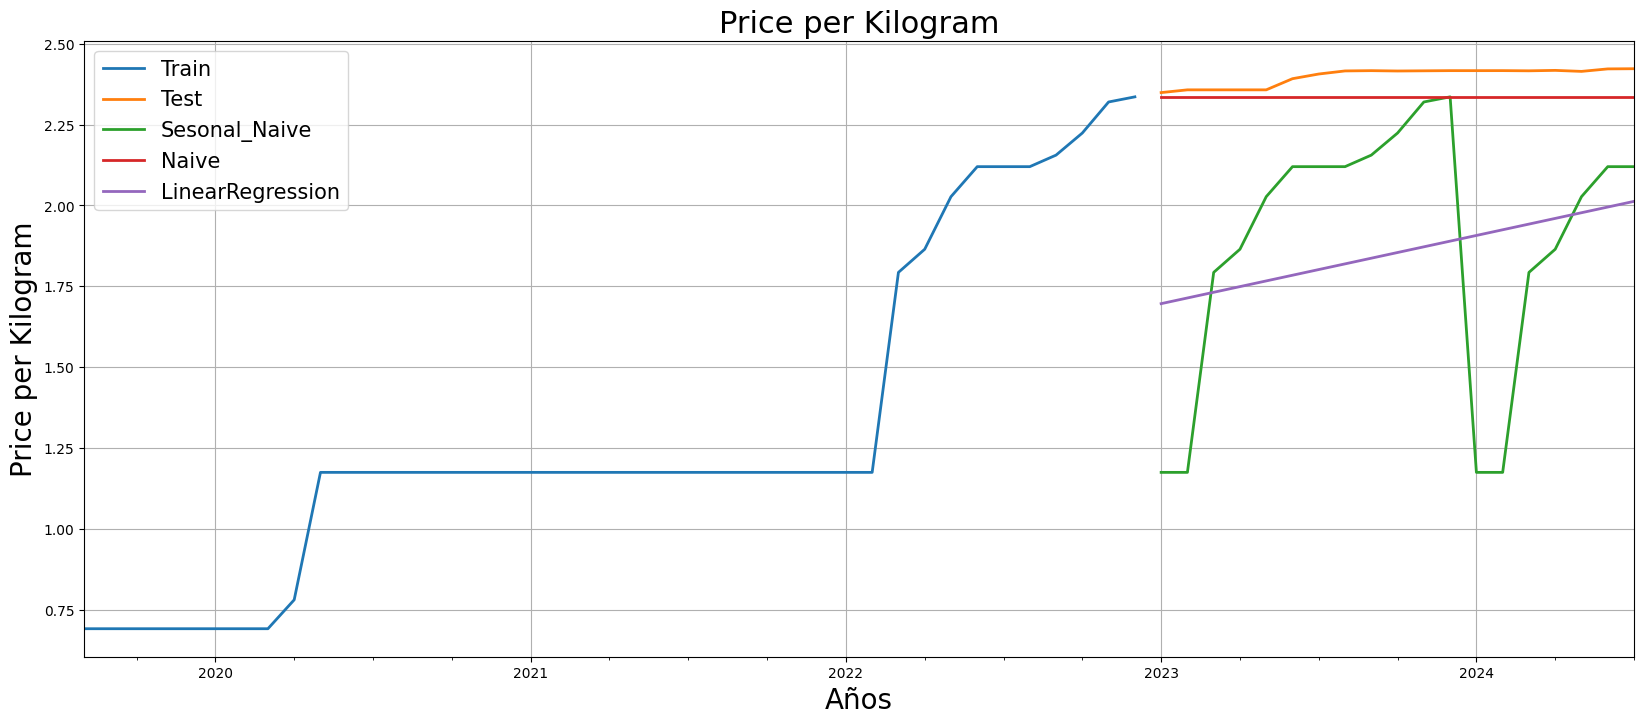

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
plot_df = pd.concat([Train_boxcox, Test_boxcox, Y_pred_df["Sesonal_Naive"], Y_pred_df["Naive"], Y_pred_df["LinearRegression"]], axis=1)
plot_df.columns = ['Train', 'Test', 'Sesonal_Naive', 'Naive', 'LinearRegression']

# Plot the values:
plot_df[-60:][['Train', 'Test', 'Sesonal_Naive', 'Naive', 'LinearRegression']].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Price per Kilogram', fontsize=22)
ax.set_ylabel('Price per Kilogram', fontsize=20)
ax.set_xlabel('Años', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

### **Regresion Lineal Multiple**

In [49]:
Train_boxcox_c = Train_boxcox
Test_boxcox_c = Test_boxcox

In [50]:
Train_boxcox = pd.DataFrame({'Price per kilogram': Train_boxcox.values}, index=Train_boxcox.index)
Test_boxcox = pd.DataFrame({'Price per kilogram': Test_boxcox.values}, index=Test_boxcox.index)

In [51]:
Train_boxcox.index = pd.to_datetime(Train_boxcox.index)
Test_boxcox.index = pd.to_datetime(Test_boxcox.index)

for i in range(1, 13):
    Train_boxcox[f'lag_{i}'] = Train_boxcox['Price per kilogram'].shift(i)
    Test_boxcox[f'lag_{i}'] = Test_boxcox['Price per kilogram'].shift(i)


In [52]:
Train_boxcox['month'] = Train_boxcox.index.month
Test_boxcox['month'] = Test_boxcox.index.month

Train_dummies = pd.get_dummies(Train_boxcox['month'], prefix='month', drop_first=True)
Test_dummies = pd.get_dummies(Test_boxcox['month'], prefix='month', drop_first=True)

Train_boxcox = pd.concat([Train_boxcox, Train_dummies], axis=1)
Test_boxcox = pd.concat([Test_boxcox, Test_dummies], axis=1)


In [53]:
Train_boxcox['price_diff'] = Train_boxcox['Price per kilogram'].diff()
Test_boxcox['price_diff'] = Test_boxcox['Price per kilogram'].diff()


In [54]:
Train_boxcox['outlier'] = ((Train_boxcox.index.year == 2022) & (Train_boxcox.index.month.isin([2, 3, 4, 5, 6]))).astype(int)
Test_boxcox['outlier'] = ((Test_boxcox.index.year == 2022) & (Test_boxcox.index.month.isin([2, 3, 4, 5, 6]))).astype(int)


In [55]:
Train_boxcox['GB_price'] = df_GB.loc[Train_boxcox.index]
Test_boxcox['GB_price'] = df_GB.loc[Test_boxcox.index]

Train_boxcox['ZMB_price'] = df_ZMB.loc[Train_boxcox.index]
Test_boxcox['ZMB_price'] = df_ZMB.loc[Test_boxcox.index]

Train_boxcox['ZM_price'] = df_ZM.loc[Train_boxcox.index]
Test_boxcox['ZM_price'] = df_ZM.loc[Test_boxcox.index]


In [56]:
Train_boxcox[Train_dummies.columns] = Train_dummies.fillna(0).astype(int)
Test_boxcox[Test_dummies.columns] = Test_dummies.fillna(0).astype(int)

Train_boxcox.fillna(0, inplace=True)
Test_boxcox.fillna(0, inplace=True)

In [57]:
Train_boxcox

,Price per kilogram,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,month_8,month_9,month_10,month_11,month_12,price_diff,outlier,GB_price,ZMB_price,ZM_price
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,-1.362399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0.000000,0,5.767059,5.800000,8.388333
2007-02-01,-1.709545,-1.362399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,-0.347146,0,5.751304,5.751304,8.311304
2007-03-01,-1.714338,-1.709545,-1.362399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,-0.004793,0,5.730000,5.730000,8.336923
2007-04-01,-1.706384,-1.714338,-1.709545,-1.362399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0.007954,0,5.730000,5.730000,8.329091
2007-05-01,-1.698577,-1.706384,-1.714338,-1.709545,-1.362399,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0.007807,0,5.773478,5.773478,8.310000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,2.120031,2.120031,2.120031,2.027168,1.864579,1.792995,1.174414,1.174414,1.174414,1.174414,...,1,0,0,0,0,0.000000,0,13.285714,13.150000,22.000000
2022-09-01,2.155741,2.120031,2.120031,2.120031,2.027168,1.864579,1.792995,1.174414,1.174414,1.174414,...,0,1,0,0,0,0.035710,0,13.758333,12.933333,22.350000
2022-10-01,2.224087,2.155741,2.120031,2.120031,2.120031,2.027168,1.864579,1.792995,1.174414,1.174414,...,0,0,1,0,0,0.068346,0,14.084615,12.984615,22.961538


In [58]:
X_train = Train_boxcox.drop(columns=['Price per kilogram'])  # Remueve la variable objetivo
y_train = Train_boxcox['Price per kilogram']

X_test = Test_boxcox.drop(columns=['Price per kilogram'])
y_test = Test_boxcox['Price per kilogram']

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_hat_train = model_lr.predict(X_train)
y_hat_test = model_lr.predict(X_test)

Y_pred_df["LinearRegression_Multiple"] = y_hat_test


In [59]:
residuals_train = y_train[12:] - y_hat_train[12:]
residuals_test = y_test - y_hat_test
rmse_train = np.sqrt(np.mean(residuals_train**2))
rmse_test = np.sqrt(np.mean(residuals_test**2))

tabla_modelos = pd.concat([tabla_modelos,
           pd.DataFrame(columns=['Modelo', 'RMSE Train', 'RMSE Test', 'Parametros'],
                        data=[['LinearRegression_Multiple', rmse_train, rmse_test, len(model_lr.coef_)]])])

tabla_modelos


,Modelo,RMSE Train,RMSE Test,Parametros
0,Seasonal Naive,0.373089,0.646123,0
0,Navive,0.072645,0.068909,0
0,LinearRegression,0.229171,0.550063,1
0,LinearRegression_Multiple,0.047014,0.431237,29


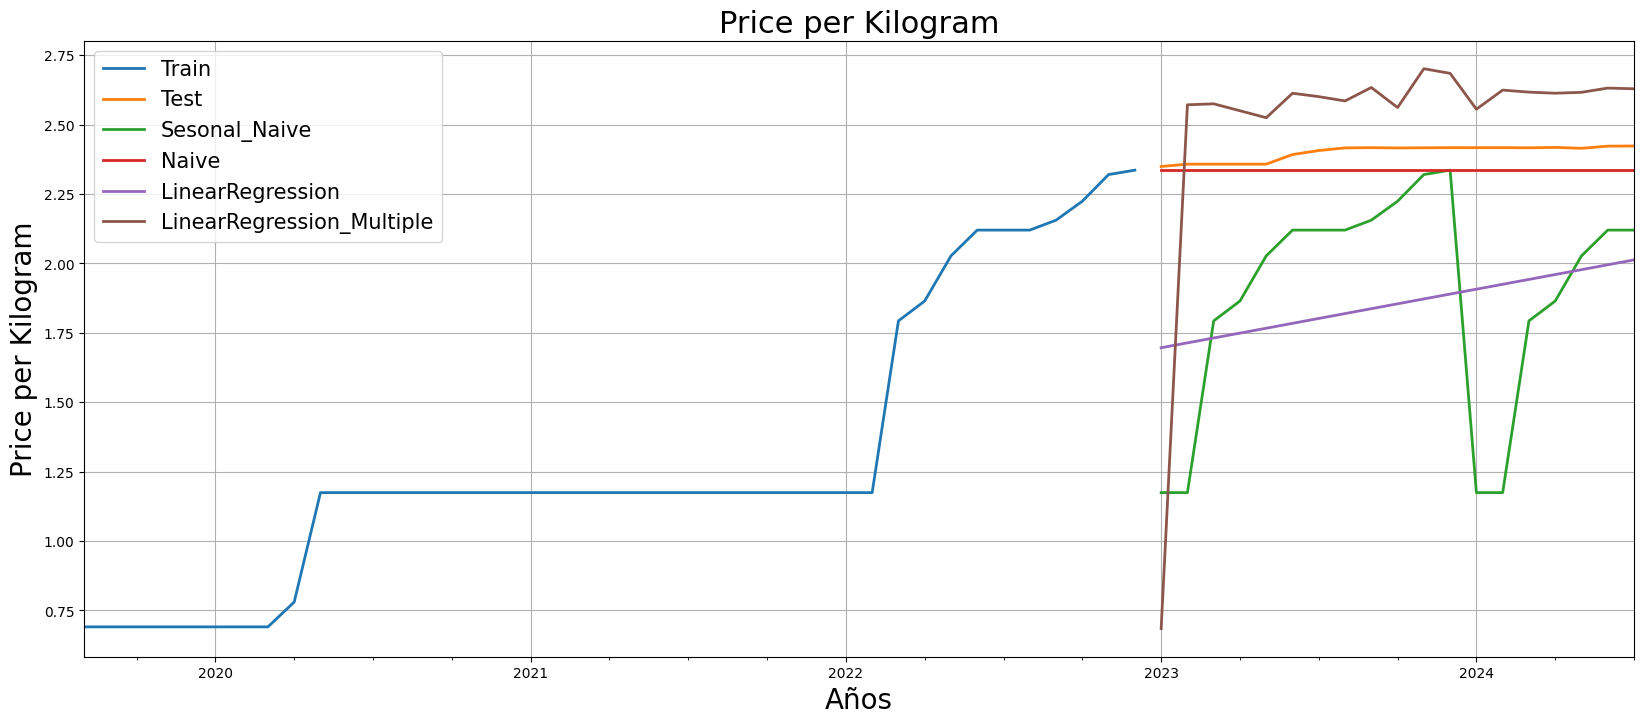

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

plot_df = pd.concat([Train_boxcox_c, Test_boxcox_c, 
                    Y_pred_df["Sesonal_Naive"], 
                    Y_pred_df["Naive"], 
                    Y_pred_df["LinearRegression"],
                    Y_pred_df["LinearRegression_Multiple"]], axis=1)
plot_df.columns = ['Train', 'Test', 'Sesonal_Naive', 'Naive', 'LinearRegression', 'LinearRegression_Multiple']

plot_df[-60:][['Train', 'Test', 'Sesonal_Naive', 'Naive', 'LinearRegression', 'LinearRegression_Multiple']].plot(ax=ax, linewidth=2)

ax.set_title('Price per Kilogram', fontsize=22)
ax.set_ylabel('Price per Kilogram', fontsize=20)
ax.set_xlabel('Años', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

plt.show()


###  **Lasso y Ridge**

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_lasso = GridSearchCV(Lasso(), param_grid, cv=5)
grid_lasso.fit(X_train, y_train)

best_alpha_lasso = grid_lasso.best_params_['alpha']
print("Mejor alpha para Lasso:", best_alpha_lasso)

grid_ridge = GridSearchCV(Ridge(), param_grid, cv=5)
grid_ridge.fit(X_train, y_train)

best_alpha_ridge = grid_ridge.best_params_['alpha']
print("Mejor alpha para Ridge:", best_alpha_ridge)


Mejor alpha para Lasso: 0.01
Mejor alpha para Ridge: 0.01


In [62]:
X_train = Train_boxcox.drop(columns=['Price per kilogram'])  
y_train = Train_boxcox['Price per kilogram']

X_test = Test_boxcox.drop(columns=['Price per kilogram'])    
y_test = Test_boxcox['Price per kilogram']


In [63]:
alpha_lasso = 0.01  
model_lasso = Lasso(alpha=alpha_lasso)
model_lasso.fit(X_train, y_train)

y_hat_train_lasso = model_lasso.predict(X_train)
y_hat_test_lasso = model_lasso.predict(X_test)

rmse_train_lasso = mean_squared_error(y_train, y_hat_train_lasso, squared=False)
rmse_test_lasso = mean_squared_error(y_test, y_hat_test_lasso, squared=False)

tabla_modelos = pd.concat([tabla_modelos,
           pd.DataFrame(columns=['Modelo', 'RMSE Train', 'RMSE Test', 'Parametros'],
                        data=[['Lasso', rmse_train_lasso, rmse_test_lasso, alpha_lasso]])])


c:\Users\esteb\miniconda3\envs\ITESO\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\esteb\miniconda3\envs\ITESO\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [64]:
alpha_ridge = 0.01  

model_ridge = Ridge(alpha=alpha_ridge)
model_ridge.fit(X_train, y_train)


y_hat_train_ridge = model_ridge.predict(X_train)
y_hat_test_ridge = model_ridge.predict(X_test)

rmse_train_ridge = mean_squared_error(y_train, y_hat_train_ridge, squared=False)
rmse_test_ridge = mean_squared_error(y_test, y_hat_test_ridge, squared=False)

tabla_modelos = pd.concat([tabla_modelos,
           pd.DataFrame(columns=['Modelo', 'RMSE Train', 'RMSE Test', 'Parametros'],
                        data=[['Ridge', rmse_train_ridge, rmse_test_ridge, alpha_ridge]])])


c:\Users\esteb\miniconda3\envs\ITESO\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\esteb\miniconda3\envs\ITESO\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [65]:
tabla_modelos

,Modelo,RMSE Train,RMSE Test,Parametros
0,Seasonal Naive,0.373089,0.646123,0.00
0,Navive,0.072645,0.068909,0.00
0,LinearRegression,0.229171,0.550063,1.00
0,LinearRegression_Multiple,0.047014,0.431237,29.00
0,Lasso,0.100447,0.404288,0.01
0,Ridge,0.080994,0.430694,0.01


### **ElasticNet**

In [66]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],  
    'l1_ratio': [0.1, 0.5, 0.9, 1.0]  
}

elastic_net = ElasticNet()

grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [67]:
best_model = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'])
best_model.fit(X_train, y_train)

y_hat_train_en = best_model.predict(X_train)
y_hat_test_en = best_model.predict(X_test)

rmse_train_en = mean_squared_error(y_train, y_hat_train_en, squared=False)
rmse_test_en = mean_squared_error(y_test, y_hat_test_en, squared=False)

tabla_modelos = pd.concat([tabla_modelos,
           pd.DataFrame(columns=['Modelo', 'RMSE Train', 'RMSE Test', 'Parametros'],
                        data=[['ElasticNet', rmse_train_en, rmse_test_en, best_params]])])

c:\Users\esteb\miniconda3\envs\ITESO\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\esteb\miniconda3\envs\ITESO\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [68]:
Y_pred_df["ElasticNet"] = best_model.predict(X_test)

In [69]:
tabla_modelos

,Modelo,RMSE Train,RMSE Test,Parametros
0,Seasonal Naive,0.373089,0.646123,0.0
0,Navive,0.072645,0.068909,0.0
0,LinearRegression,0.229171,0.550063,1.0
0,LinearRegression_Multiple,0.047014,0.431237,29.0
0,Lasso,0.100447,0.404288,0.01
0,Ridge,0.080994,0.430694,0.01
0,ElasticNet,0.191979,0.400516,"{'alpha': 1, 'l1_ratio': 0.1}"


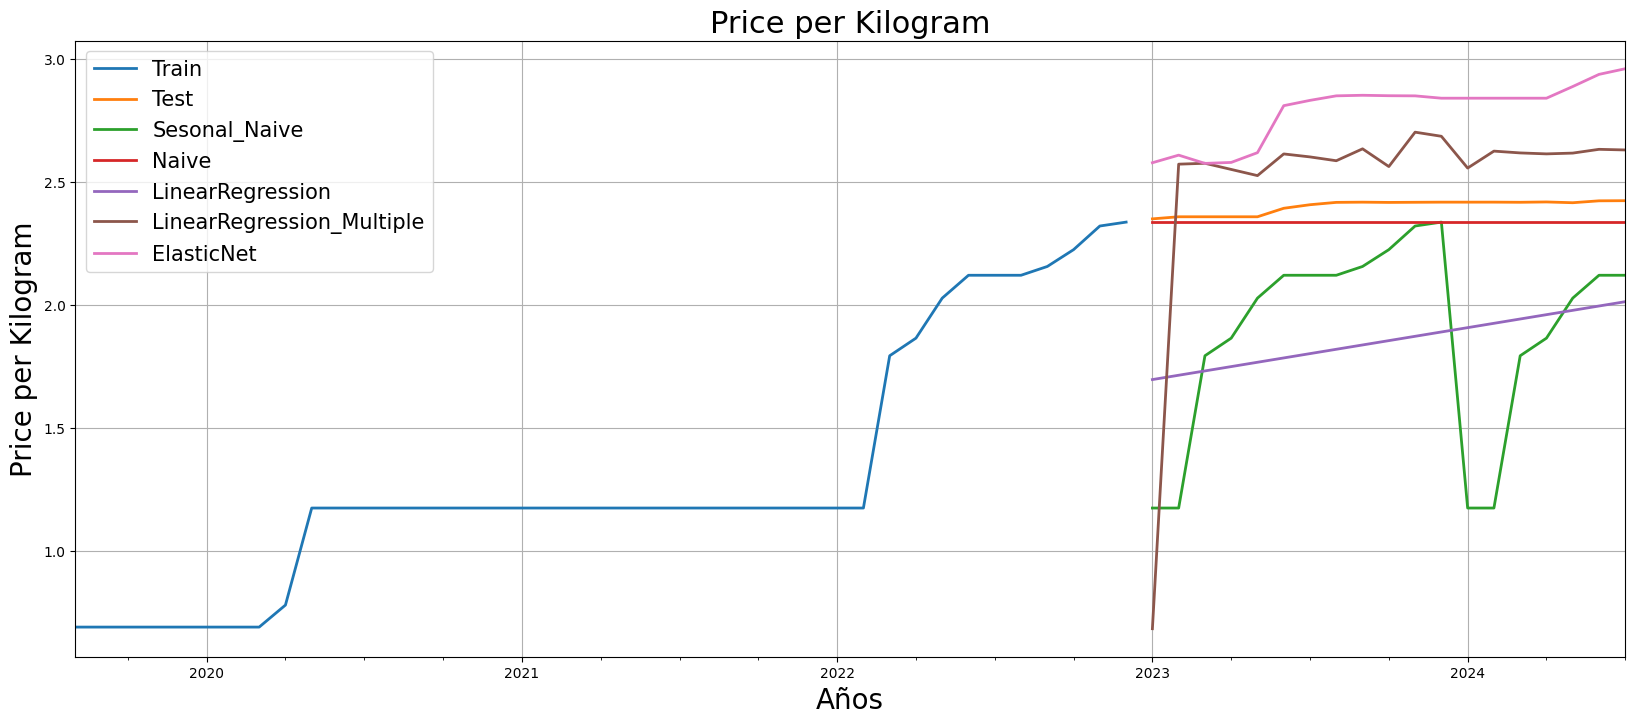

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Graficar
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

plot_df = pd.concat([
    Train_boxcox_c, 
    Test_boxcox_c, 
    Y_pred_df["Sesonal_Naive"], 
    Y_pred_df["Naive"], 
    Y_pred_df["LinearRegression"], 
    Y_pred_df["LinearRegression_Multiple"],
    Y_pred_df["ElasticNet"]  # Agregar predicciones de Elastic Net
], axis=1)

plot_df.columns = [
    'Train', 'Test', 
    'Sesonal_Naive', 'Naive', 
    'LinearRegression', 
    'LinearRegression_Multiple',
    'ElasticNet'  # Nombre para la columna de Elastic Net
]

plot_df[-60:][[
    'Train', 'Test', 
    'Sesonal_Naive', 'Naive', 
    'LinearRegression', 
    'LinearRegression_Multiple', 
    'ElasticNet'  # Incluir Elastic Net en el gráfico
]].plot(ax=ax, linewidth=2)

ax.set_title('Price per Kilogram', fontsize=22)
ax.set_ylabel('Price per Kilogram', fontsize=20)
ax.set_xlabel('Años', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

plt.show()


## **Conclusion**

Podemos observar como en efecto el sesonal_naive fue uno de los peores modelos de predicion esto ya que como antes veimos los datos no presentan una estacionalidad como tal. Tambien podemos observar como la regression lineal multiple se ajuste de una muy buena manera a los datos sin embargo vemos que presenta un muy fuerte error al incio de la prediccon la cual vemos como se ve reducida en gran medida por la regression en la que se aplica la regularizacion de elasticnet dado como resultado que entre estos dos se encuentre el mejor modelo para predicir el precio de la tortilla 